This script is for qulity check. It qualify the $NO_x$, $NO_y$, $O_3$, and $O_3$ sensitivity results during the side-by-side comparison test in Davis, and Pasadena.

In [3]:
import os, importlib, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression

# local module
sys.path.insert(0, '../../code/src')
#importlib.reload(sys.modules['extract_chamber_data'])
from extract_chamber_data import list_of_measurement_day
from extract_chamber_data import get_NOxNOyO3_filepath
from extract_chamber_data import get_raw_lvm
from extract_chamber_data import get_raw_O3
from extract_chamber_data import get_raw_NOx

In [4]:
print('Days with side-by-side comparison \n', 
      list_of_measurement_day('Redlands', test_type='qa/qc'))

Days with side-by-side comparison 
 ['11/3/2021', '11/4/2021', '11/5/2021', '11/5/2021_night', '11/6/2021', '11/7/2021', '11/7/2021_night', '11/8/2021', '11/8/2021_night', '11/9/2021']


## $NO_x$ (ambient) comparison in side-by-side comparison

In [10]:
# get NOx from Redlands (raw NOx data without correction)
list_NOx_file = ['../../data/raw/Chamber/Redlands/NOx/Measurement_110321.txt',
                 '../../data/raw/Chamber/Redlands/NOx/Measurement_110421.txt',
                 '../../data/raw/Chamber/Redlands/NOx/Measurement_110521.txt',
                 '../../data/raw/Chamber/Redlands/NOx/Measurement_110621.txt',
                 '../../data/raw/Chamber/Redlands/NOx/Measurement_110721.txt']

df_NOx_RL = pd.DataFrame(columns=['Time', 'NO', 'NOx', 'NO2'])
for filepath_NOx in list_NOx_file:
    df_NOx = get_raw_NOx(filepath_NOx, correction=False)
    df_NOx_RL = pd.concat([df_NOx_RL, df_NOx], axis=0)

# get NOx from Pasadena (raw NOx data without correction)
list_NOx_file = ['../../data/raw/Chamber/Pasadena/NOx/Measurement_110321.txt',
                 '../../data/raw/Chamber/Pasadena/NOx/Measurement_110421.txt',
                 '../../data/raw/Chamber/Pasadena/NOx/Measurement_110521.txt',
                 '../../data/raw/Chamber/Pasadena/NOx/Measurement_110621.txt',
                 '../../data/raw/Chamber/Pasadena/NOx/Measurement_110721.txt']

df_NOx_PA = pd.DataFrame(columns=['Time', 'NO', 'NOx', 'NO2'])
for filepath_NOx in list_NOx_file:
    df_NOx = get_raw_NOx(filepath_NOx, correction=False)
    df_NOx_PA = pd.concat([df_NOx_PA, df_NOx], axis=0)

# merge two NOx dfs
df_NOx_merge = df_NOx_RL.merge(df_NOx_PA, on='Time', how='inner')
df_NOx_merge.columns = ['Time', 'NO_RL', 'NOx_RL', 'NO2_RL', 'NO_PA', 'NOx_PA', 'NO2_PA']

In [11]:
# start and end time of chamber measurement 
# (last 4 hours, give warm up time 10min before and 20min after)
time_chamber_start = pd.to_datetime(['2021-11-03 11:41:00', '2021-11-04 11:42:00', 
                                       '2021-11-05 11:33:00', '2021-11-05 19:24:00',
                                       '2021-11-06 12:07:00','2021-11-07 11:37:00',
                                       '2021-11-07 20:25:00']) - pd.Timedelta('10 minute')
time_chamber_end = time_chamber_start + pd.Timedelta('4 hours') + pd.Timedelta('30 minute')

In [15]:
df_NOx_merge_ambient = df_NOx_merge[(~((df_NOx_merge['Time']>=time_chamber_start[0])&
                (df_NOx_merge['Time']<=time_chamber_end[0])))&
             (~((df_NOx_merge['Time']>=time_chamber_start[1])&
                (df_NOx_merge['Time']<=time_chamber_end[1])))&
             (~((df_NOx_merge['Time']>=time_chamber_start[2])&
                (df_NOx_merge['Time']<=time_chamber_end[2])))&
             (~((df_NOx_merge['Time']>=time_chamber_start[3])&
                (df_NOx_merge['Time']<=time_chamber_end[3])))&
             (~((df_NOx_merge['Time']>=time_chamber_start[4])&
                (df_NOx_merge['Time']<=time_chamber_end[4])))&
             (~((df_NOx_merge['Time']>=time_chamber_start[5])&
                (df_NOx_merge['Time']<=time_chamber_end[5])))&
             (~((df_NOx_merge['Time']>=time_chamber_start[6])&
                (df_NOx_merge['Time']<=time_chamber_end[6])))].reset_index(drop=True)

# delete all value < 100
df_NOx_merge_ambient = df_NOx_merge_ambient[(df_NOx_merge_ambient['NOx_RL']<80)&
                                            (df_NOx_merge_ambient['NOx_PA']<80)]

In [16]:
NOx_PA = df_NOx_merge_ambient.groupby(df_NOx_merge_ambient['Time'].\
                                      dt.strftime('%Y-%m-%d %H')).\
                              apply(lambda x: stats.trim_mean(x['NOx_PA'], 0.2))
NOx_RL = df_NOx_merge_ambient.groupby(df_NOx_merge_ambient['Time'].\
                                      dt.strftime('%Y-%m-%d %H')).\
                              apply(lambda x: stats.trim_mean(x['NOx_RL'], 0.2))

Text(0, 0.5, 'NOx_PA')

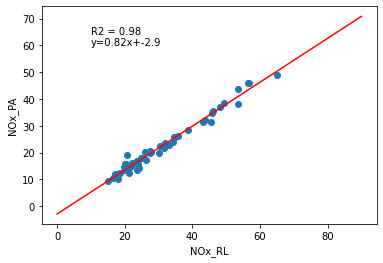

In [17]:
from extract_chamber_data import linearRegssion_withNaN 

X = NOx_RL.iloc[1:]
Y = NOx_PA.iloc[1:]
coef, intercept, r_value = linearRegssion_withNaN(X, Y)

plt.scatter(X, Y)
plt.plot(np.arange(0,100,10), coef*np.arange(0,100,10)+intercept, color='red')
plt.text(10, 60, 'R2 = '+str(round(r_value**2, 2)) + '\n' + 'y=' + str(round(coef, 2)) + 'x+' + str(round(intercept, 2)))

plt.xlabel('NOx_RL')
plt.ylabel('NOx_PA')